In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

In [4]:
from torchvision import transforms
from data import datasets, trans
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from utils.model_utils import *
from torch.utils.data import DataLoader

/home/duanbin/anaconda3/envs/binmorph/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def normalize_disp(flow, grid):
    shape = flow.shape[2:]
    new_locs = flow + grid

    # need to normalize grid values to [-1, 1] for resampler
    for i in range(len(shape)):
        new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)
        
    return new_locs

In [6]:
def warp_consistent_flow(fg_flow, bg_flow, warper):
    disp_fg = normalize_disp(fg_flow, warper.grid)
    
    warped_disp = img_warper(disp_fg, bg_flow)
    
    return warped_disp

In [7]:
def mk_grid_img(grid_step, line_thickness=1, grid_sz=(160, 192, 224)):
    grid_img = np.zeros(grid_sz, dtype=np.float32)
    for j in range(0, grid_img.shape[1], grid_step):
        grid_img[:, j+line_thickness-1, :] = 1
    for i in range(0, grid_img.shape[0], grid_step):
        grid_img[i+line_thickness-1, ...] = 1
    grid_img = grid_img[None, None, ...]
    grid_img = torch.from_numpy(grid_img).cuda()
    return grid_img

In [8]:
def plot_and_save_fig(img, title=None):
    img = img.cpu().numpy().squeeze()
    plt.imshow(img[..., 112].T)
    plt.box('off')
    plt.axis('off')
    plt.tight_layout()
    if title:
        plt.savefig(f'{title}.png', bbox_inches='tight', pad_inches=0., dpi=1200)

In [32]:
# data
# dataloaders
IXI_test_composed = transforms.Compose([trans.Seg_norm(),
                                    trans.NumpyType((np.float32, np.int16)),
                                    ])
IXI_test_set = datasets.IXIBrainInferDataset(glob.glob('/data/duanbin/image_registration/dataset/IXI_data/Test/' + '*.pkl'),
                                             '/data/duanbin/image_registration/dataset/IXI_data/atlas.pkl',
                                             transforms=IXI_test_composed)

IXI_test_loader = DataLoader(IXI_test_set, batch_size=1, shuffle=False, num_workers=1, pin_memory=True, drop_last=True)

for batch_idx, data in enumerate(IXI_test_loader):
    data = [t.to('cuda:0', non_blocking=True) for t in data]
    x, y, _, _ = data
    if batch_idx == 15:
        break

In [33]:
plot_and_save_fig(y, title='cross/fix')

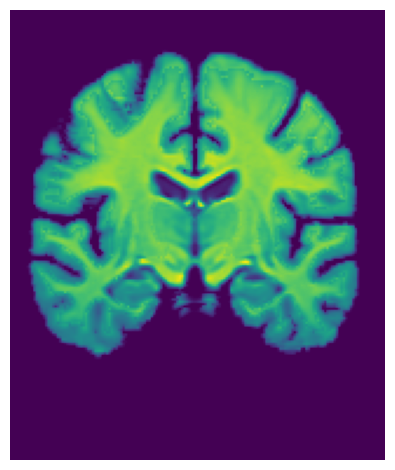

In [34]:
plot_and_save_fig(x, title='cross/mov')

In [35]:
# warper
img_warper = SpatialWarper((160, 192, 224))
img_warper.cuda()

SpatialWarper()

In [36]:
# grid
grid_img = mk_grid_img(8, 1)

In [37]:
# model
strict_ckpt = '/data/duanbin/image_registration/experiments/CNN/VoxelMorph/sanity_checked/GPU_5epoch_500lr_0.001weighting_Fixedalpha_0.0beta_0.0flag_sim_Trueflag_grad_Trueflag_self_Trueflag_cross_True/dsc0.715.pth.tar'
checkpoint = torch.load(strict_ckpt, map_location='cuda:0')
strict_register = load_model('voxelmorph2', checkpoint, (160, 192, 224))

In [38]:
with torch.no_grad():
    strict_fg_flow = strict_register(x, y)
    strict_bg_flow = strict_register(y, x)

    strict_warped = warp_consistent_flow(strict_fg_flow, strict_bg_flow, img_warper)
    
    strict_def_mov = img_warper(x, strict_fg_flow)
    strict_grid = img_warper(grid_img, strict_fg_flow)
    strict_warped_grid = img_warper(grid_img, strict_warped)

In [39]:
relaxed_ckpt = '/data/duanbin/image_registration/experiments/CNN/VoxelMorph/sanity_checked/GPU_5epoch_500lr_0.001weight_[0.001, 0.1]alpha_0.1beta_12flag_sim_Trueflag_grad_Trueflag_self_Trueflag_cross_True/dsc0.718.pth.tar'
checkpoint = torch.load(relaxed_ckpt, map_location='cuda:0')
relaxed_register = load_model('voxelmorph2', checkpoint, (160, 192, 224))

In [40]:
with torch.no_grad():
    relaxed_fg_flow = relaxed_register(x, y)
    relaxed_bg_flow = relaxed_register(y, x)

    relaxed_warped = warp_consistent_flow(relaxed_fg_flow, relaxed_bg_flow, img_warper)
    
    relaxed_def_mov = img_warper(x, relaxed_fg_flow)
    relaxed_grid = img_warper(grid_img, relaxed_fg_flow)
    relaxed_warped_grid = img_warper(grid_img, relaxed_warped)

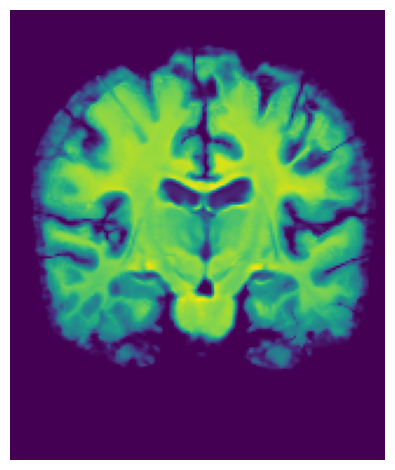

In [41]:
plot_and_save_fig(strict_def_mov, title='cross/strict_def_mov')

In [42]:
plot_and_save_fig(relaxed_def_mov, title='cross/relaxed_def_mov')

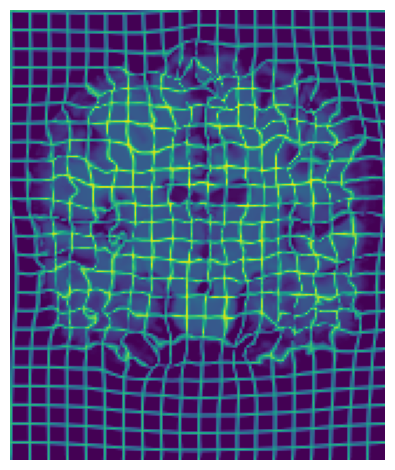

In [43]:
plot_and_save_fig(strict_grid + strict_def_mov, title='cross/strict_def_grid')

In [45]:
tmp = strict_grid + strict_def_mov
tmp = tmp.cpu().numpy().squeeze()
tmp = tmp[..., 112].T

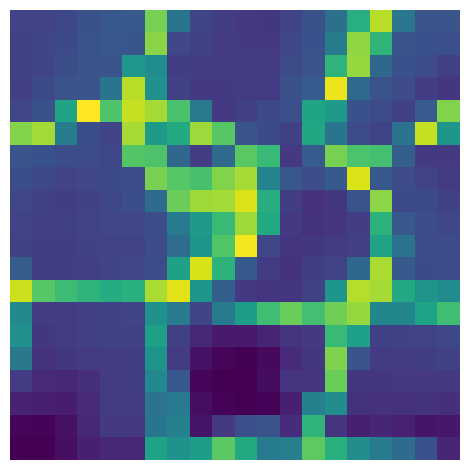

In [48]:
plt.imshow(tmp[143-20:143, 26:46])
plt.box('off')
plt.axis('off')
plt.tight_layout()
plt.savefig('cross/strict_small.png', bbox_inches='tight', pad_inches=0., dpi=1200)

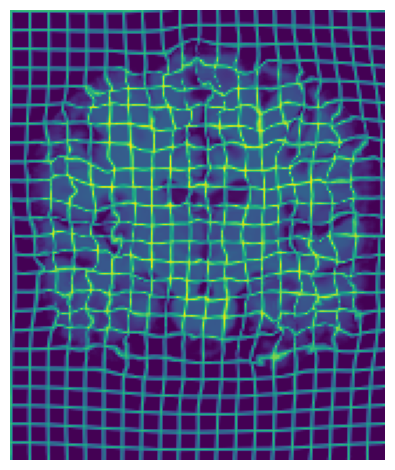

In [49]:
plot_and_save_fig(relaxed_grid + relaxed_def_mov, title='cross/relaxed_def_grid')

In [50]:
tmp = relaxed_grid + relaxed_def_mov
tmp = tmp.cpu().numpy().squeeze()
tmp = tmp[..., 112].T

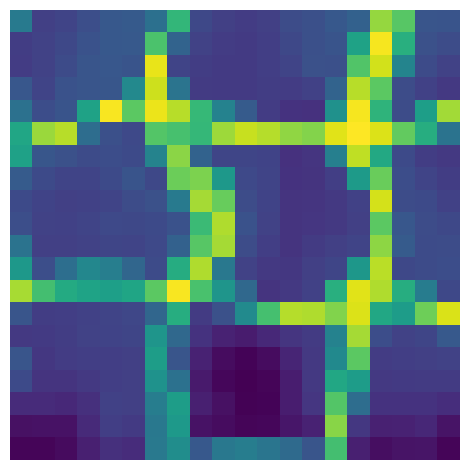

In [51]:
plt.imshow(tmp[143-20:143, 26:46])
plt.box('off')
plt.axis('off')
plt.tight_layout()
plt.savefig('cross/relaxed_small.png', bbox_inches='tight', pad_inches=0., dpi=1200)

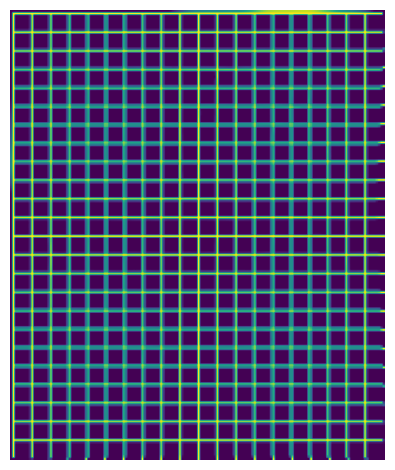

In [52]:
plot_and_save_fig(strict_warped_grid, title='cross/strict_grid')

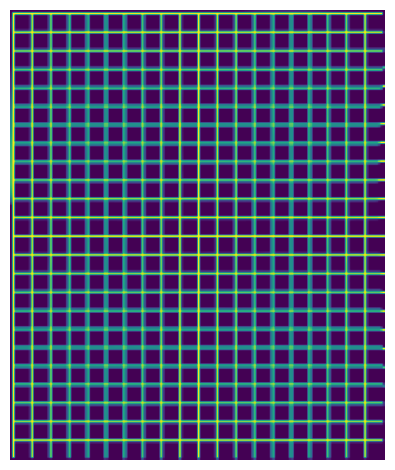

In [53]:
plot_and_save_fig(relaxed_warped_grid, title='cross/relaxed_grid')